In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date as dt

import pandas_datareader.data as pdr
import yfinance as yf
import seaborn as sns
yf.pdr_override()

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

! pip install pmdarima
from pmdarima.arima import auto_arima
import pmdarima as pm

from pandas import Series
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
start = dt(2016, 1, 1)
end = dt(2020, 1, 1)

In [3]:
df = pdr.get_data_yahoo('AMZN', start=start, end=end)  
df.info()
df.head()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2016-01-04 to 2019-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1006 non-null   float64
 1   High       1006 non-null   float64
 2   Low        1006 non-null   float64
 3   Close      1006 non-null   float64
 4   Adj Close  1006 non-null   float64
 5   Volume     1006 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.0 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,32.814499,32.886002,31.375500,31.849501,31.849501,186290000
2016-01-05,32.342999,32.345501,31.382500,31.689501,31.689501,116452000
2016-01-06,31.100000,31.989500,31.015499,31.632500,31.632500,106584000
2016-01-07,31.090000,31.500000,30.260500,30.396999,30.396999,141498000
2016-01-08,30.983000,31.207001,30.299999,30.352501,30.352501,110258000


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03
mean,63.757561,64.318716,63.076373,63.729558,63.729558,8.576559e+07
std,23.675035,23.887567,23.394806,23.645184,23.645184,4.358994e+07
min,23.900499,24.674999,23.700001,24.103500,24.103500,1.762600e+07
25%,41.033751,41.115748,40.731499,40.925875,40.925875,5.633200e+07
50%,59.936501,60.270750,59.420500,59.735750,59.735750,7.314300e+07
75%,87.474253,88.173378,86.568748,87.498249,87.498249,1.015140e+08
max,101.905502,102.525002,100.650002,101.975502,101.975502,3.313000e+08


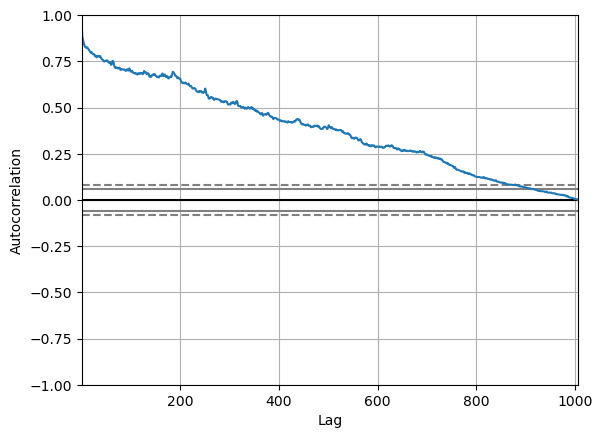

In [5]:
#plotting the autocorrelation for the original data, including all variables
autocorrelation_plot(df)
plt.show()
#shows high degree of autocorrelation, thefore not random
#makes sense, as all are the same value at different times of the day, so focus on just one

               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999656  0.999441  0.999112   0.999112  0.104011
High       0.999656  1.000000  0.999300  0.999548   0.999548  0.114650
Low        0.999441  0.999300  1.000000  0.999595   0.999595  0.086079
Close      0.999112  0.999548  0.999595  1.000000   1.000000  0.099484
Adj Close  0.999112  0.999548  0.999595  1.000000   1.000000  0.099484
Volume     0.104011  0.114650  0.086079  0.099484   0.099484  1.000000


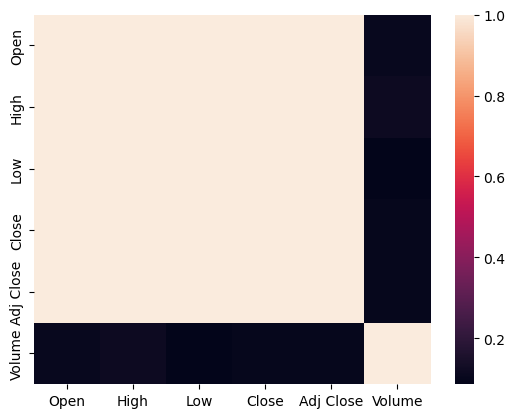

In [6]:
#another way to see th correlation is using the heatmap
print(df.corr())
sns.heatmap(df.corr())
plt.show()

Text(0, 0.5, 'Close Price')

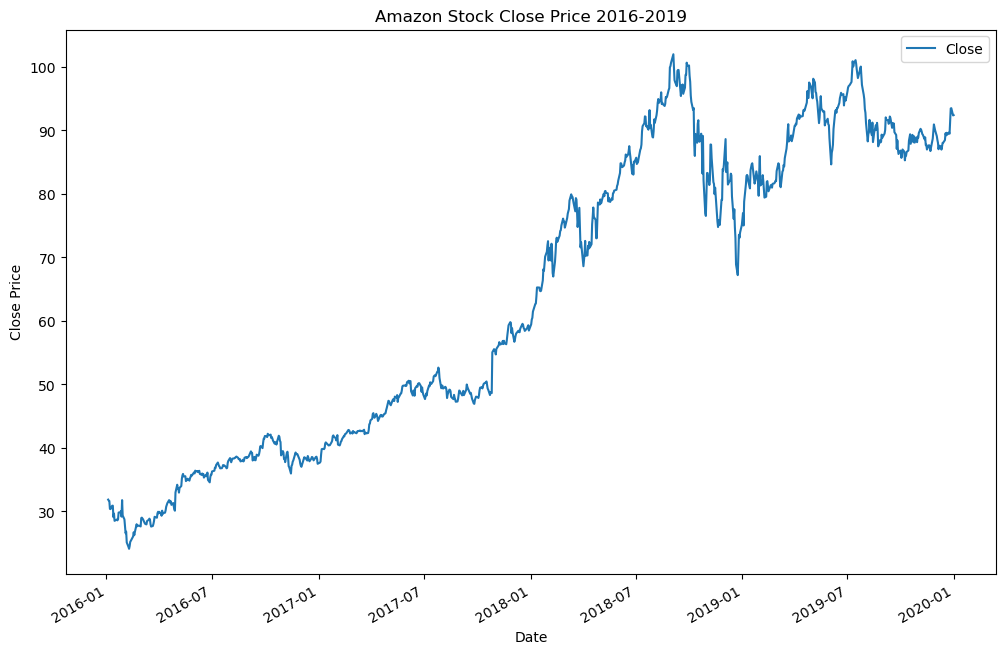

In [7]:
#here we look at the data for just the closing value
AMZN_Close=pd.DataFrame(df['Close'])
AMZN_Close.plot(figsize=(12,8))
plt.title('Amazon Stock Close Price 2016-2019')
plt.xlabel('Date')
plt.ylabel('Close Price')
#from the shape of the graphe, we can tell that the data is not stationary
#given the upward trend, meaning no constant mean

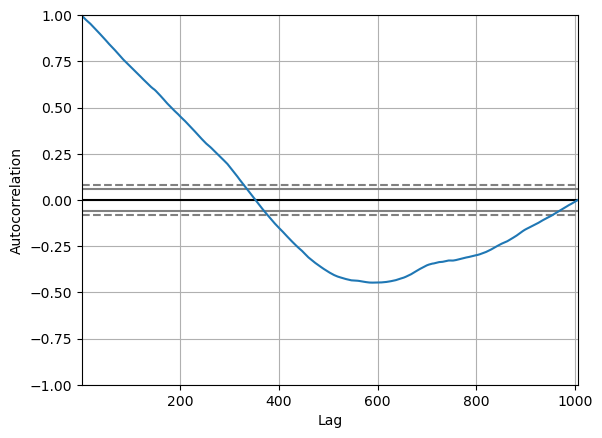

In [8]:
autocorrelation_plot(AMZN_Close)
plt.show()
#plotting the autotocorrelation for just the closing price we can also see that it is no random

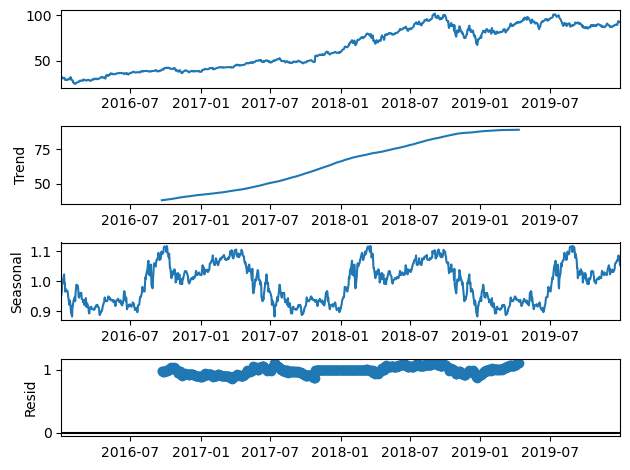

In [9]:
dcmp=seasonal_decompose(AMZN_Close, model='multiplicative', period=365).plot()
plt.show()
#we break down the data plot using the decompase method to see what is influencing
#here we can more clearly see that there is an upward trend and seasonality at play, as well as residual factors influencing
#this is a way to also see that the data is not stationary

In [10]:
#running the Augmented Dickey–Fuller test we can confrim that the data is not stationary
#to forecast time series data, specially with ARIMA model, it is better for the data to be stationary
def adfuller_test(close):
    adf = adfuller(close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(adf,labels):
        print(label+' : '+str(value) )

    if adf[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis. Data is not stationary.")

adfuller_test(AMZN_Close)

#Ho: Data is non-stationary
#H1: Data is stationary

ADF Test Statistic : -0.909739199572721
p-value : 0.7847482418230755
#Lags Used : 0
Number of Observations : 1005
Weak evidence against null hypothesis. Data is not stationary.


               Close
Date                
2016-01-05 -0.160000
2016-01-06 -0.057001
2016-01-07 -1.235500
2016-01-08 -0.044498
2016-01-11  0.534498


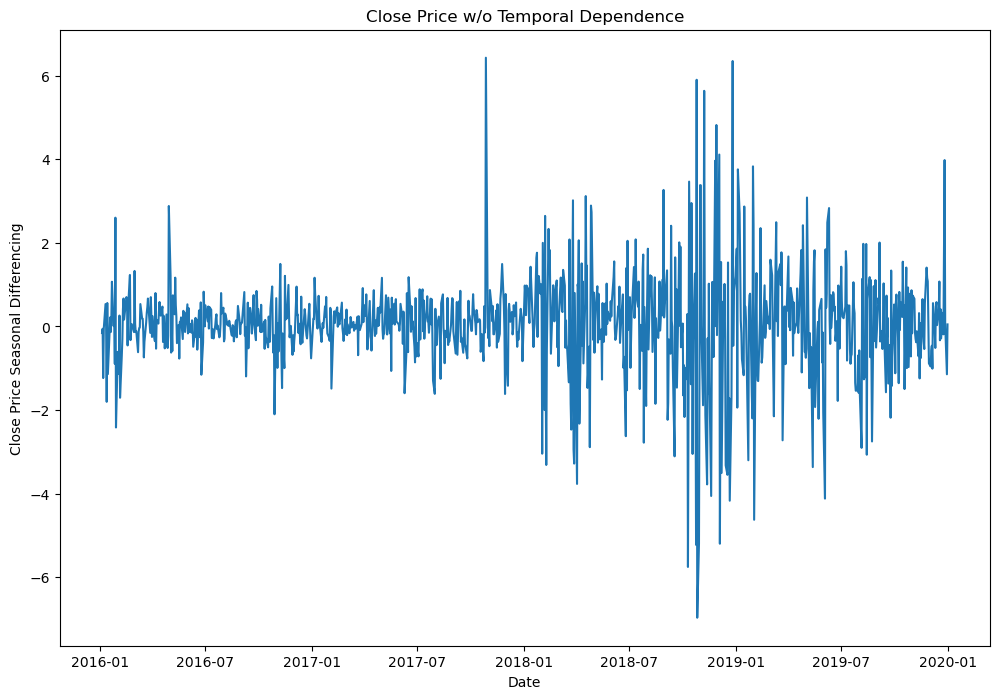

In [11]:
#to make the data stationary we put it through auto differencing
#differencing helps us to get rid of some of the temporal dependence
diff = AMZN_Close.diff()
AMZNdiff = diff.dropna()
print(AMZNdiff.head())
plt.figure(figsize=(12,8))
plt.plot(AMZNdiff)
plt.title('Close Price w/o Temporal Dependence')
plt.xlabel('Date')
plt.ylabel('Close Price Seasonal Differencing')
plt.show()

#Two manual way to ensure seasonality is being considered is highlighted below. 
#However, in this case both have produces the same outputs
# def difference(AMZN_Close, interval=1):
#     diff = list()
#     for i in range(interval, len(AMZN_Close)):
#         value = AMZN_Close[i] - AMZN_Close[i - interval]
#         diff.append(value)
#     return diff
    
# AMZNdiff= pd.DataFrame(diff)
# print (AMZNdiff)

# x = AMZN_Close.values
# diff = difference(x)
# plt.plot(diff)
# plt.show()
#>>> or <<<
# x = AMZN_Close.values
# diff = list()
# yr_days = 365
# for i in range(yr_days, len(x)):
#  value = x[i] - x[i - yr_days]
#  diff.append(value)
# plt.plot(diff)
# plt.show()




In [12]:
#data is now stationary as seen by the differencing plot showing a mean of 0
adfuller_test(AMZNdiff)
#with a p-value under 0.05, the ADF test confirms this

ADF Test Statistic : -12.626315183725314
p-value : 1.538888390659438e-23
#Lags Used : 7
Number of Observations : 997
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


C:\Users\nvbel\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


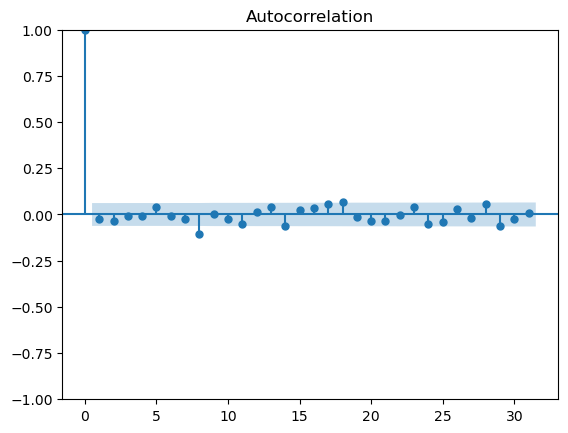

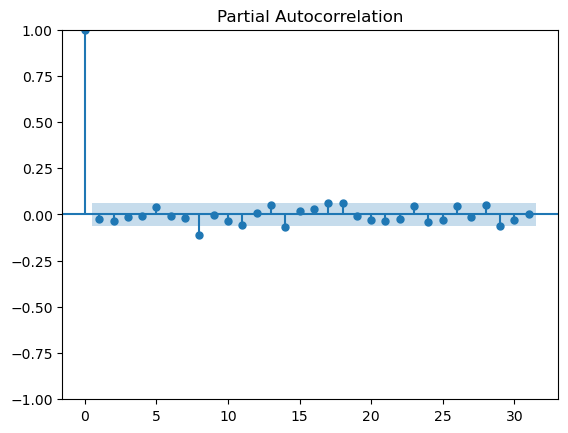

In [13]:
#Now that the data is stationary, we can begin building our model
#to pick the best pdq values, we plot the autocorrelation and partial autocorrelarion functions (ACF & PACF)
#p = number of autoregressive terms
#d = number of nonseasonal differences needed for stationarity
#q = number of lagged forecast errors in prediction equation
acf= plot_acf(AMZNdiff)
pacf= plot_pacf(AMZNdiff)
#we can observe that the only significant lag in both plots is at 0, so we may be better off using ARIMA(0,0,0)

Train Data
               Close
Date                
2016-01-05 -0.160000
2016-01-06 -0.057001
2016-01-07 -1.235500
2016-01-08 -0.044498
2016-01-11  0.534498
Test Data
               Close
Date                
2019-03-18  1.489502
2019-03-19  0.985001
2019-03-20  1.771004
2019-03-21  1.099495
2019-03-22 -2.724495


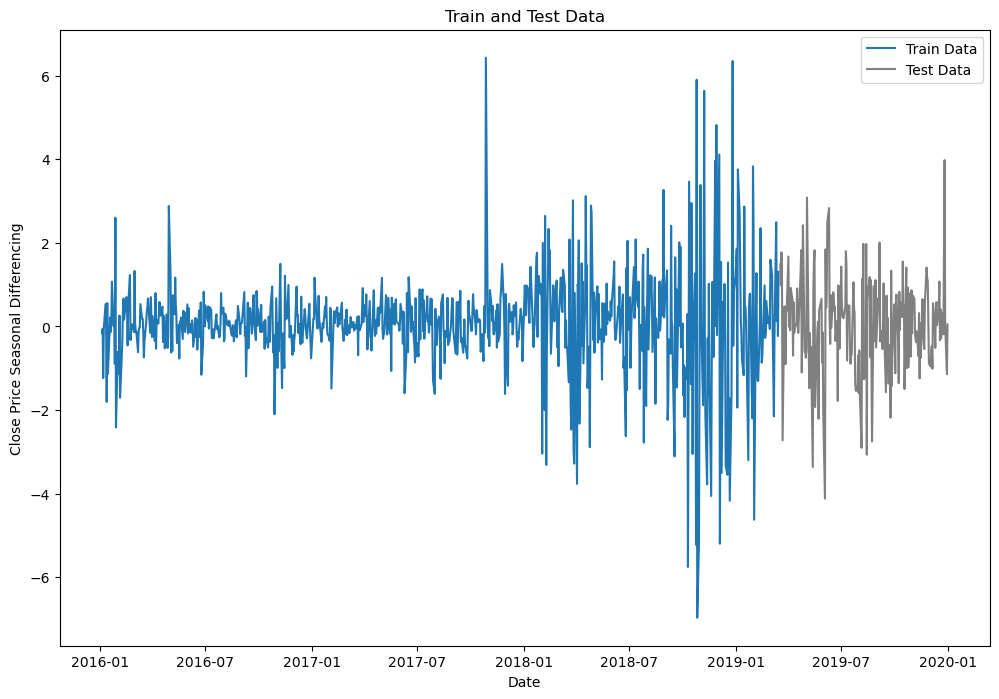

In [14]:
#Another method of finding the best ARIMA model, is by using the auto_arima function
#before we can do this, we need to split the data into test data and trainign data
#a good ratio is 80% training, 20% testing
train = AMZNdiff[:int(len(AMZNdiff)*0.8)]
print('Train Data')
print(train.head())
test = AMZNdiff[int(len(AMZNdiff)*0.8):]
print('Test Data')
print(test.head())

#here we plot just to have a visual representation of the data split
plt.figure(figsize=(12,8))
plt.plot(train, label='Train Data')
plt.plot(test, 'gray', label='Test Data')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Close Price Seasonal Differencing')

plt.legend()

In [15]:
#now we can use auto_arima with the training data
#note becuse the data is now stationary, we can make seasonal equal to false
auto = auto_arima(train, stepwise=False, seasonal=False, trace=True)
#as we predicted with the ACF/PACF, the best model is the ARIMA(0,0,0)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2586.944, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2588.133, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2589.187, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2590.944, Time=0.07 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2592.848, Time=0.06 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2592.147, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2588.188, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2588.238, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2591.017, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2592.934, Time=0.28 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2594.943, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2589.276, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2590.237, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2587.474, Time=0.48 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(3,0,0)(0

In [16]:
#Now we can go ahead and build our model
AMZNmodel=ARIMA(train,order=(0,0,0))
AMZNmodel=AMZNmodel.fit()
AMZNmodel.summary()

C:\Users\nvbel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\nvbel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\nvbel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  804
Model:                          ARIMA   Log Likelihood               -1291.237
Date:                Fri, 12 May 2023   AIC                           2586.475
Time:                        17:04:23   BIC                           2595.854
Sample:                             0   HQIC                          2590.077
                                - 804                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0669      0.043      1.569      0.117      -0.017       0.150
sigma2         1.4538      0.033     43.464      0.000       1.388       1.519
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):              1860.46
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               9.90   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

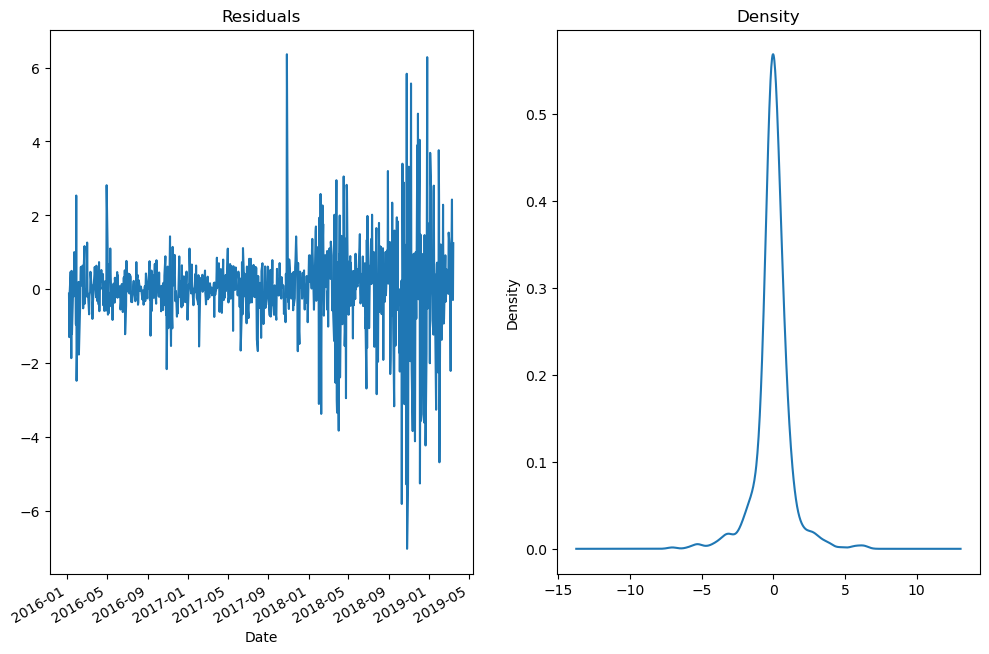

In [17]:
#to ensure we have a good fit of a model, we look at wheter the residuals have a zero mean and are evenly distrbuted
residuals = AMZNmodel.resid[1:]
fig, ax = plt.subplots(1,2,)
residuals.plot(title='Residuals', ax=ax[0], figsize=(12,8))
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()
#these condtions have been met

C:\Users\nvbel\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


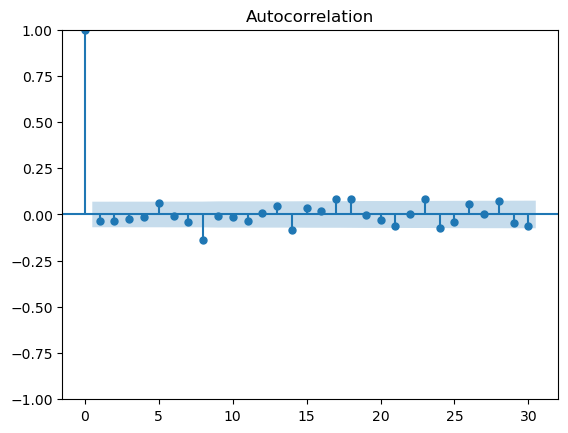

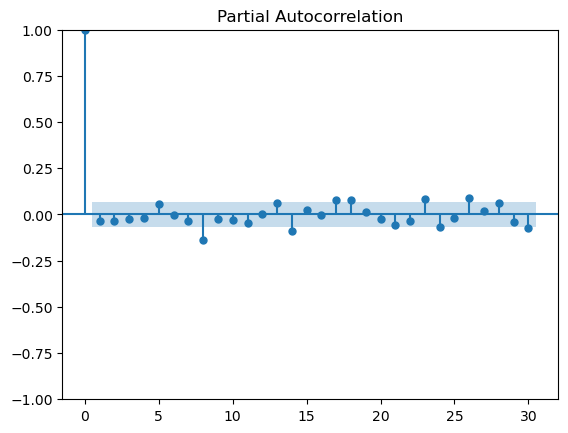

In [18]:
#we also can obsserve if the residuals are independent
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)
#with a lag of 0 in the ACF/PACF, this condition has been met

C:\Users\nvbel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\nvbel\AppData\Local\Temp\ipykernel_100444\3686604511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMZNdiff['forecast'] = [None]*len(train) + list(forecast)


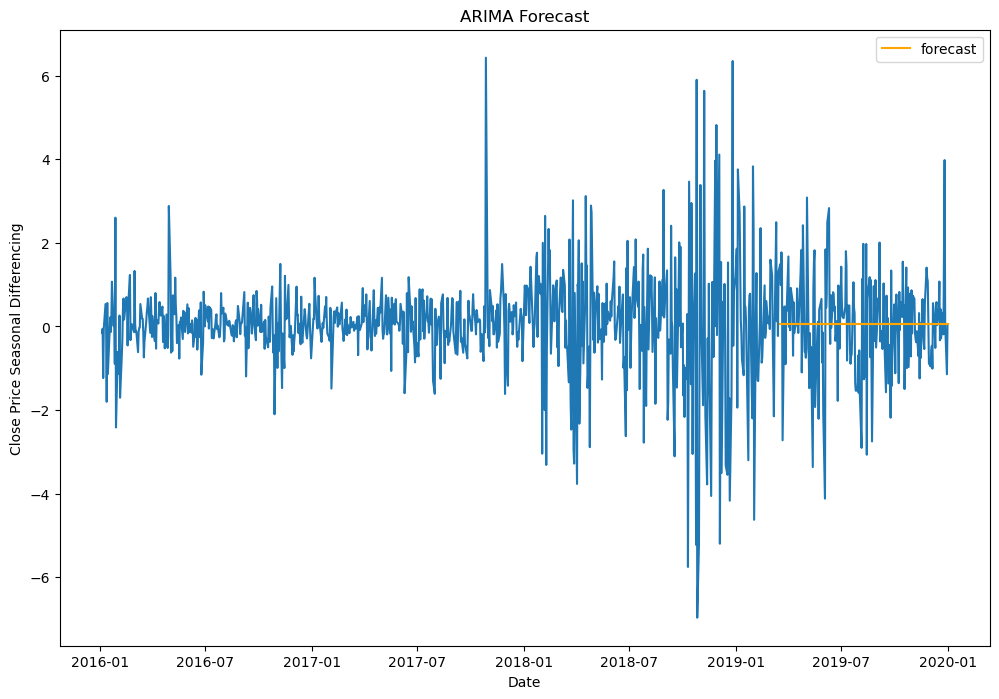

In [19]:
#the testing data can now be used to forecast
forecast = (AMZNmodel.forecast(len(test)))
AMZNdiff['forecast'] = [None]*len(train) + list(forecast) #adding a forecast column to the data

plt.figure(figsize=(12,8))
plt.plot(AMZNdiff)
plt.plot(AMZNdiff['forecast'],color='orange',label='forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price Seasonal Differencing')
plt.legend()


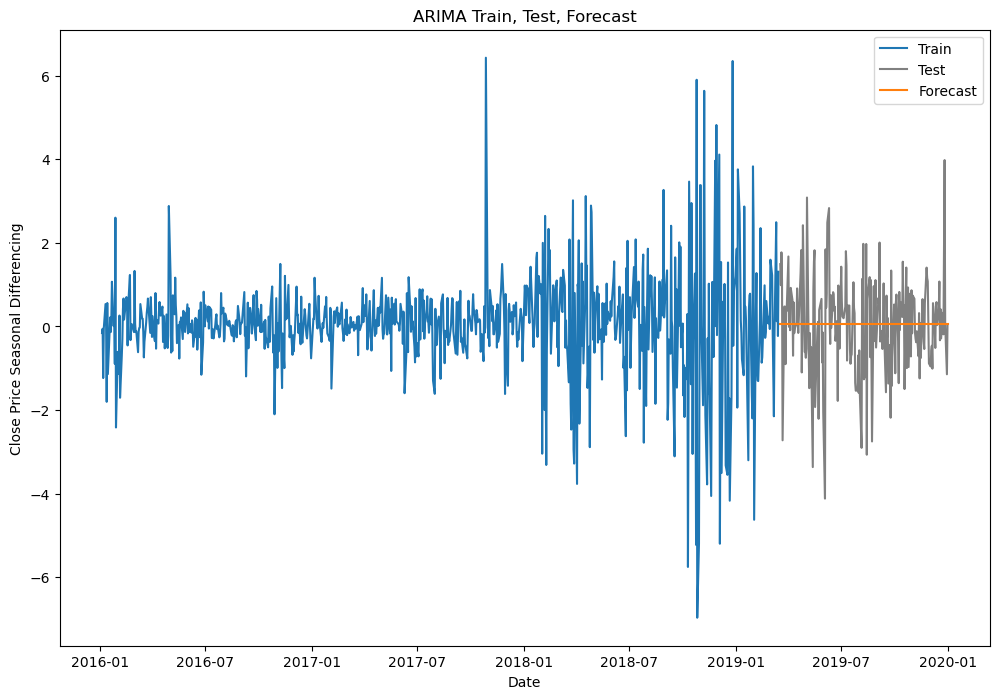

In [20]:
#We can visualize the training, testing, and forecast data all in one plot
predict = pd.DataFrame(forecast)
predict = predict.set_index(test.index)

plt.figure(figsize=(12,8))
plt.plot(train, label='Train')
plt.plot(test, color='gray', label='Test')
plt.plot(predict,label='Forecast')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price Seasonal Differencing')
plt.title('ARIMA Train, Test, Forecast')

plt.show()

In [21]:
#to check for the accuracy of our model, we look at the mae, mape, and rmse
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')
#the lower the value the more accurate the model
#we can interprest the given values as having come up with an accurate model

mae: 0.8699956885955642
mape: 1.0889808908054155
rmse: 1.1483057809097377


In [22]:
#we can trye to predict further into the future
#first we must create the predicted mean dataset for the future dates
#in this case, we decided to try to see 90 days into the future
x = AMZNmodel.predict(len(AMZNdiff),len(AMZNdiff)+89 )
ftr_pred = pd.DataFrame(x)
ftr_pred.index = pd.DatetimeIndex(ftr_pred.index)
ftr_pred = ftr_pred.set_index(pd.date_range(AMZNdiff.index[-1], periods =90, freq='D'))
ftr_pred.head()

C:\Users\nvbel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,predicted_mean
2019-12-31,0.066871
2020-01-01,0.066871
2020-01-02,0.066871
2020-01-03,0.066871
2020-01-04,0.066871


C:\Users\nvbel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


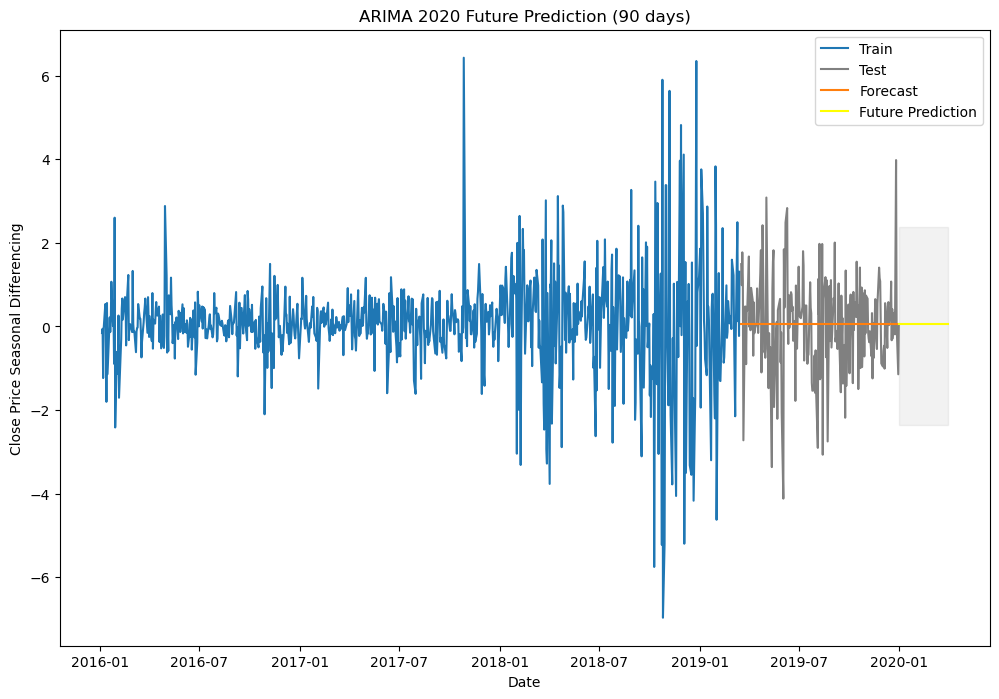

In [23]:
# with the predicted mean data we can forecast and include a 95% confidence interval area
n_periods = 90
AMZNmodel, confint = auto.predict(n_periods, return_conf_int=True)
pred_index = pd.date_range(AMZNdiff.index[-1], periods = n_periods, freq='D')

# this series will help us visualize the shaded confidence area in the plot
fitted_series = pd.Series(AMZNmodel, index=pred_index)
lower_series = pd.Series(confint[:, 0], index=pred_index)
upper_series = pd.Series(confint[:, 1], index=pred_index)

plt.figure(figsize=(12,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='gray')
plt.plot(predict,label='Forecast')
plt.plot(ftr_pred, color='yellow', label='Future Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)

plt.title("ARIMA 2020 Future Prediction (90 days)")
plt.xlabel('Date')
plt.ylabel('Close Price Seasonal Differencing')
plt.legend()
plt.show()

In [24]:
#to see how are future predictions compare to what actually happend in those first 90 days of 2020
#we will first dowload the data for the time period
start20 = dt(2019, 12, 31)
end20 = dt(2020, 4, 1)
df20 = pdr.get_data_yahoo('AMZN', start=start20, end=end20)  
df20['Date']=df20.index
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,32.814499,32.886002,31.375500,31.849501,31.849501,186290000
2016-01-05,32.342999,32.345501,31.382500,31.689501,31.689501,116452000
2016-01-06,31.100000,31.989500,31.015499,31.632500,31.632500,106584000
2016-01-07,31.090000,31.500000,30.260500,30.396999,30.396999,141498000
2016-01-08,30.983000,31.207001,30.299999,30.352501,30.352501,110258000


Date
2020-01-02    2.508499
2020-01-03   -1.152000
2020-01-06    1.395500
2020-01-07    0.199005
2020-01-08   -0.744499
Name: Close, dtype: float64


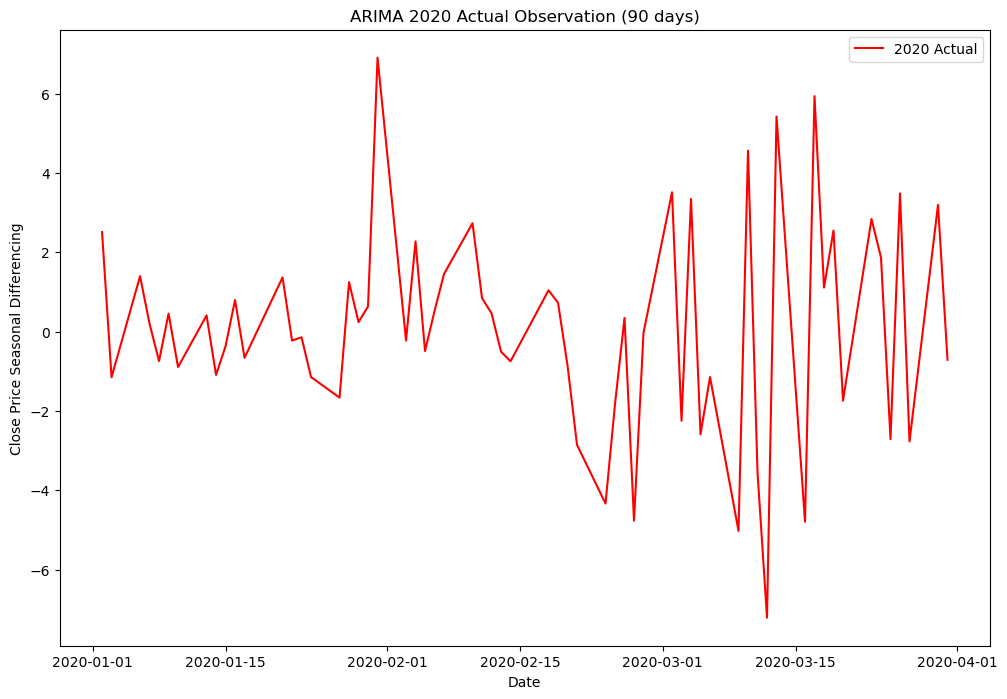

In [25]:
#as with the previous data we will make it stationary
diff20 = df20['Close'].diff()
AMZNdiff20 = diff20.dropna()
print(AMZNdiff20.head())
plt.figure(figsize=(12,8))
plt.plot(AMZNdiff20, color='red', label='2020 Actual')
plt.title("ARIMA 2020 Actual Observation (90 days)")
plt.xlabel('Date')
plt.ylabel('Close Price Seasonal Differencing')
plt.legend()
plt.show()


C:\Users\nvbel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


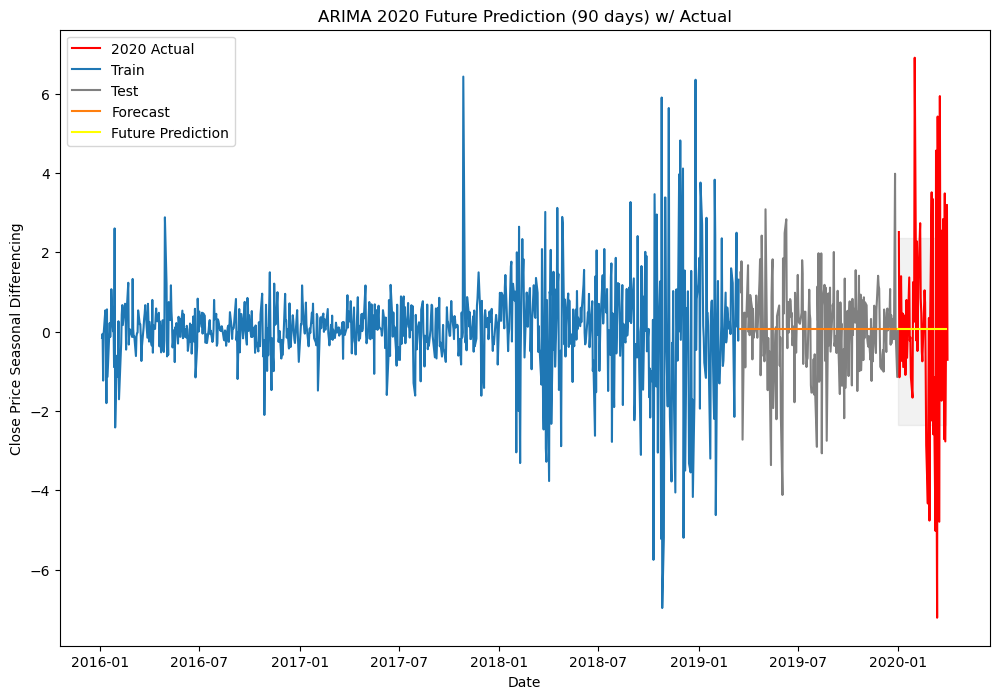

In [26]:
#Now we can combine the prediction with the actual in one plot
n_periods = 90
AMZNmodel, confint = auto.predict(n_periods, return_conf_int=True)
pred_index = pd.date_range(AMZNdiff.index[-1], periods = n_periods, freq='D')

fitted_series = pd.Series(AMZNmodel, index=pred_index)
lower_series = pd.Series(confint[:, 0], index=pred_index)
upper_series = pd.Series(confint[:, 1], index=pred_index)

plt.figure(figsize=(12,8))
plt.plot(AMZNdiff20, color='red', label='2020 Actual')
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='gray')
plt.plot(predict,label='Forecast')
plt.plot(ftr_pred, color='yellow', label='Future Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)

plt.title("ARIMA 2020 Future Prediction (90 days) w/ Actual")
plt.xlabel('Date')
plt.ylabel('Close Price Seasonal Differencing')
plt.legend()
plt.show()

#we can observe that the actual data goes well out of our 95% confidence area
#we beleive that the positive impacts of the 2020 pandemic on Amazon's business may have played a major role in this